# Practicum II - Movie Database Applicaton
### Collaborators: Abasamia Akpan, Rebecca Brent and Alessia Pizzoccheri

This Notebook provides context, documentation and sample code for a Database Application using IMBd datasets; for clarity, this document has been divided into the following sections:

### 1. Schemas and Models
### 2. Parsing and Importing the Data
### 3. Procedures and Triggers
### 4. Views
### 5. Queries
### 6. Functions
### 7. Indexes
----
### 1. Schemas and Models

#### 1.1. Looking at the data
In this section, we analyze and deconstruct the various data sets found on the IMBd page; data is organized in seven TSV files, specifically:
1. Title AKAs
2. Title Basics
3. Title Episodes
4. Title Ratings
5. Title Crew
6. Name Basics
7. Title Principles 

For semplicity, some of the tables mentioned above will not be part of our model and schema. 

Our first step is to establish relationships between each data set and identify a primary key (PK) on each table. Since no information was provided regarding the role of each column, we devised a solution to find unique identifiers within each data set; that is, for each table we compare the total number of rows against the total number of unique values for a given column.

#### 1.2 Logical Model and Relational Schema
Following the previously mentioned method, we identified the following relational schema and logical model.

TITLE_BASICS(<u>t_const</u>,genres, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_mins);

NAME_BASICS(<u>n_const</u>, known_for_titles, primary_name, birth_year, death_year, primary_profession);

TITLE_RATINGS(<u>t_const</u>, num_votes, average_rating);

TITLE_EPISODES(<u>t_const</u>, season_num, eposiode_num, parent_t_const);


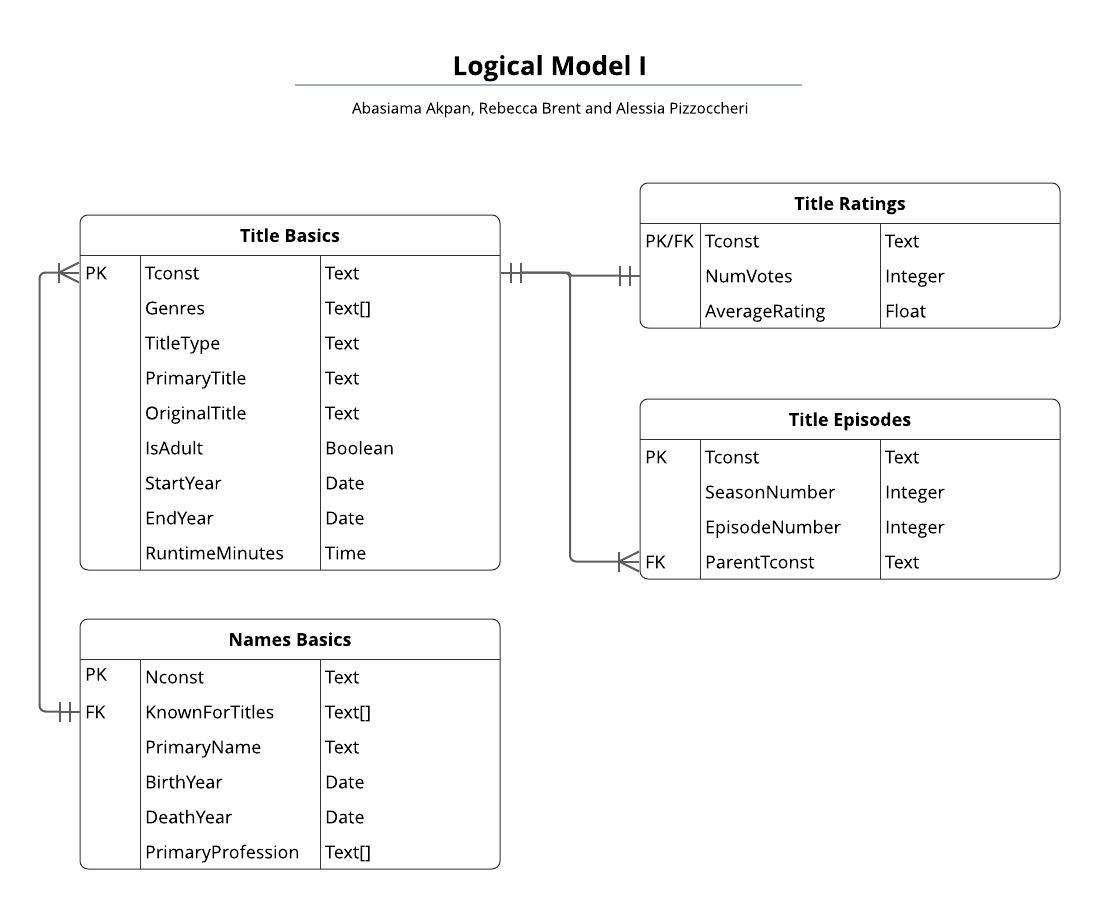

#### 1.3 Refactoring the Model and Schema
Our next step is to remove and refactor the schema and model to eliminate any _many-to-many_ relationships; the new model and schema are presented below.

TITLE_BASICS(<u>t_const</u>, title_type, primary_title, original_title, is_adult, start_year, end_year, runtime_mins); 

NAME_BASICS(<u>n_const</u>, primary_name, birth_year, death_year, primary_profession);

TITLE_RATINGS(<u>t_const</u>, num_votes, average_rating);

TITLE_EPISODES(<u>t_const</u>, season_num, eposiode_num, parent_t_const);

TITLE_GENRES(<u>title_basics_id</u>, <u>genre_id</u>)

GENRES(<u>genre_id</u>, name)

KNOWN_FOR_TITLES(<u>name_basics_id</u>, <u>known_for_titles</u>)

NAME_PRIMARY_PROFESSION(<u>primary_profession_id</u>, <u>name_basics_id</u>)

PRIMARY_PROFESSION(<u>primary_profession_id</u>, name)


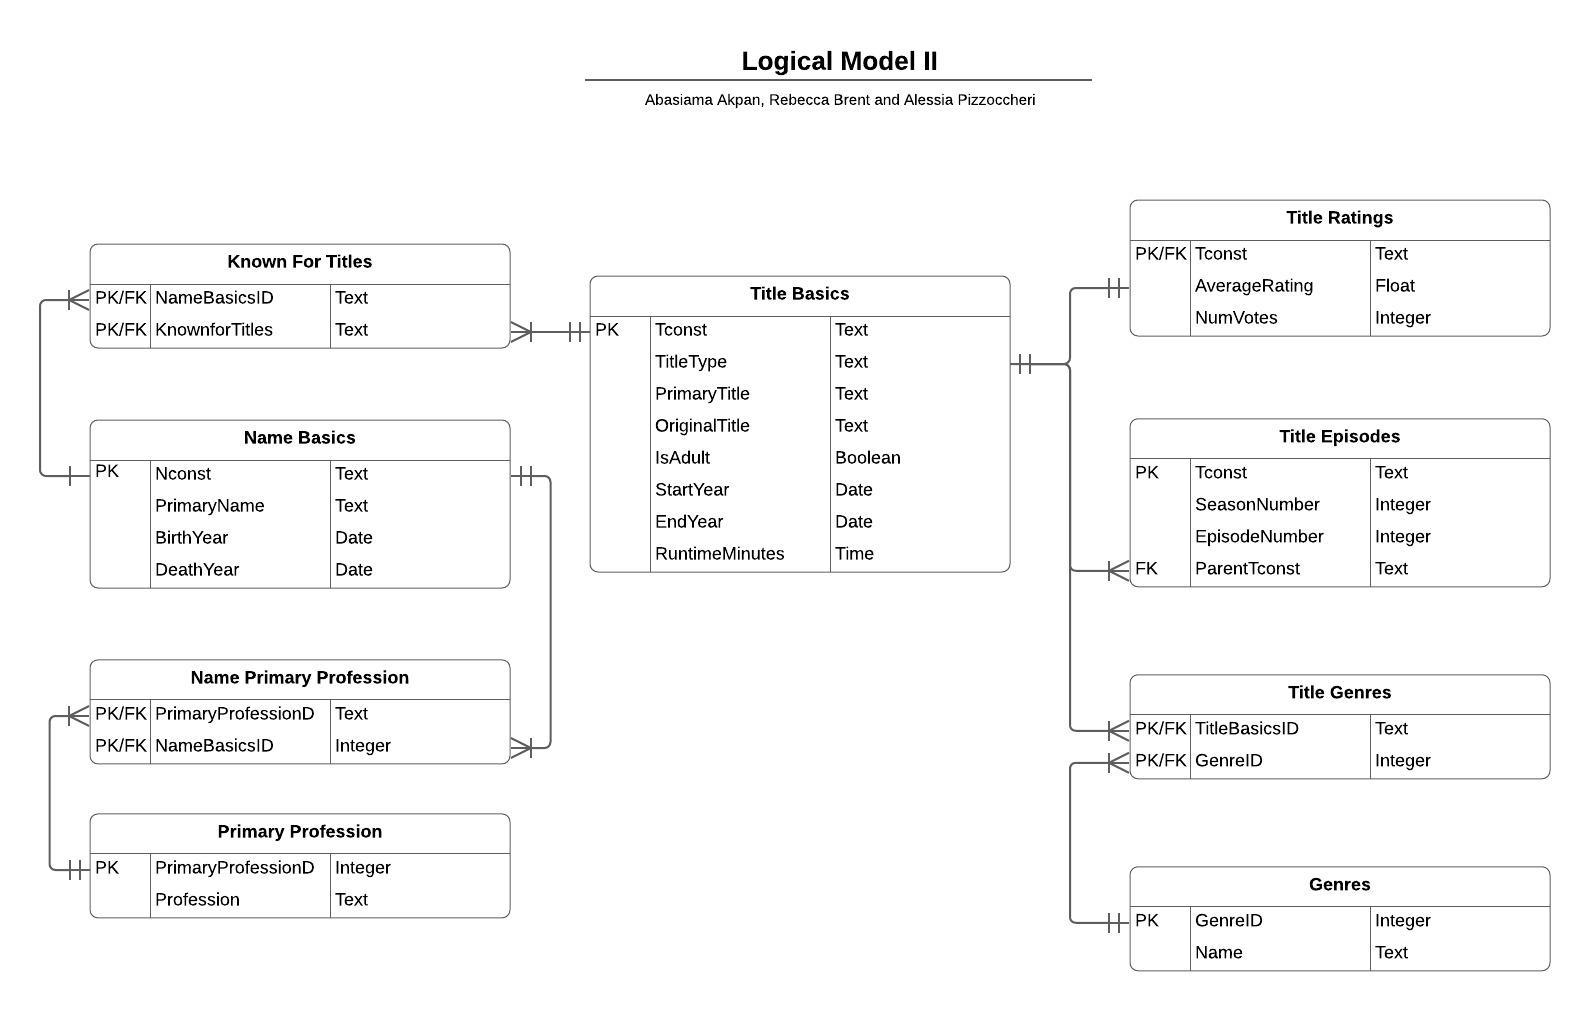

#### 1.3 Updating the Model and Schema with additional columns
Finally, we update our model and schema by adding two additional columns to our _NAME_BASICS_ table; specifically, we included two columns: 

TITLE_BASICS(<u>tconst</u>, titleType, primaryTitle, original_title, isAdult, startYear, endYear, runtimeMins); 

NAME_BASICS(<u>nconst</u>, primaryName, birthYear, deathYear, age, noOfMovies);

TITLE_RATINGS(<u>tconst</u>, num_votes, average_rating);

TITLE_EPISODES(<u>tconst</u>, season_num, episode_num, parent_t_const);

TITLE_GENRES(<u>titlebasicsID</u>, <u>genreID</u>)

GENRES(<u>genreID</u>, name)

KNOWN_FOR_TITLES(<u>namebasicsID</u>, <u>knownForTitle</u>)

NAME_PRIMARY_PROFESSION(<u>primaryProfessionID</u>, <u>nameBasicsID</u>)

PRIMARY_PROFESSION(<u>primaryProfessionID</u>, profession)


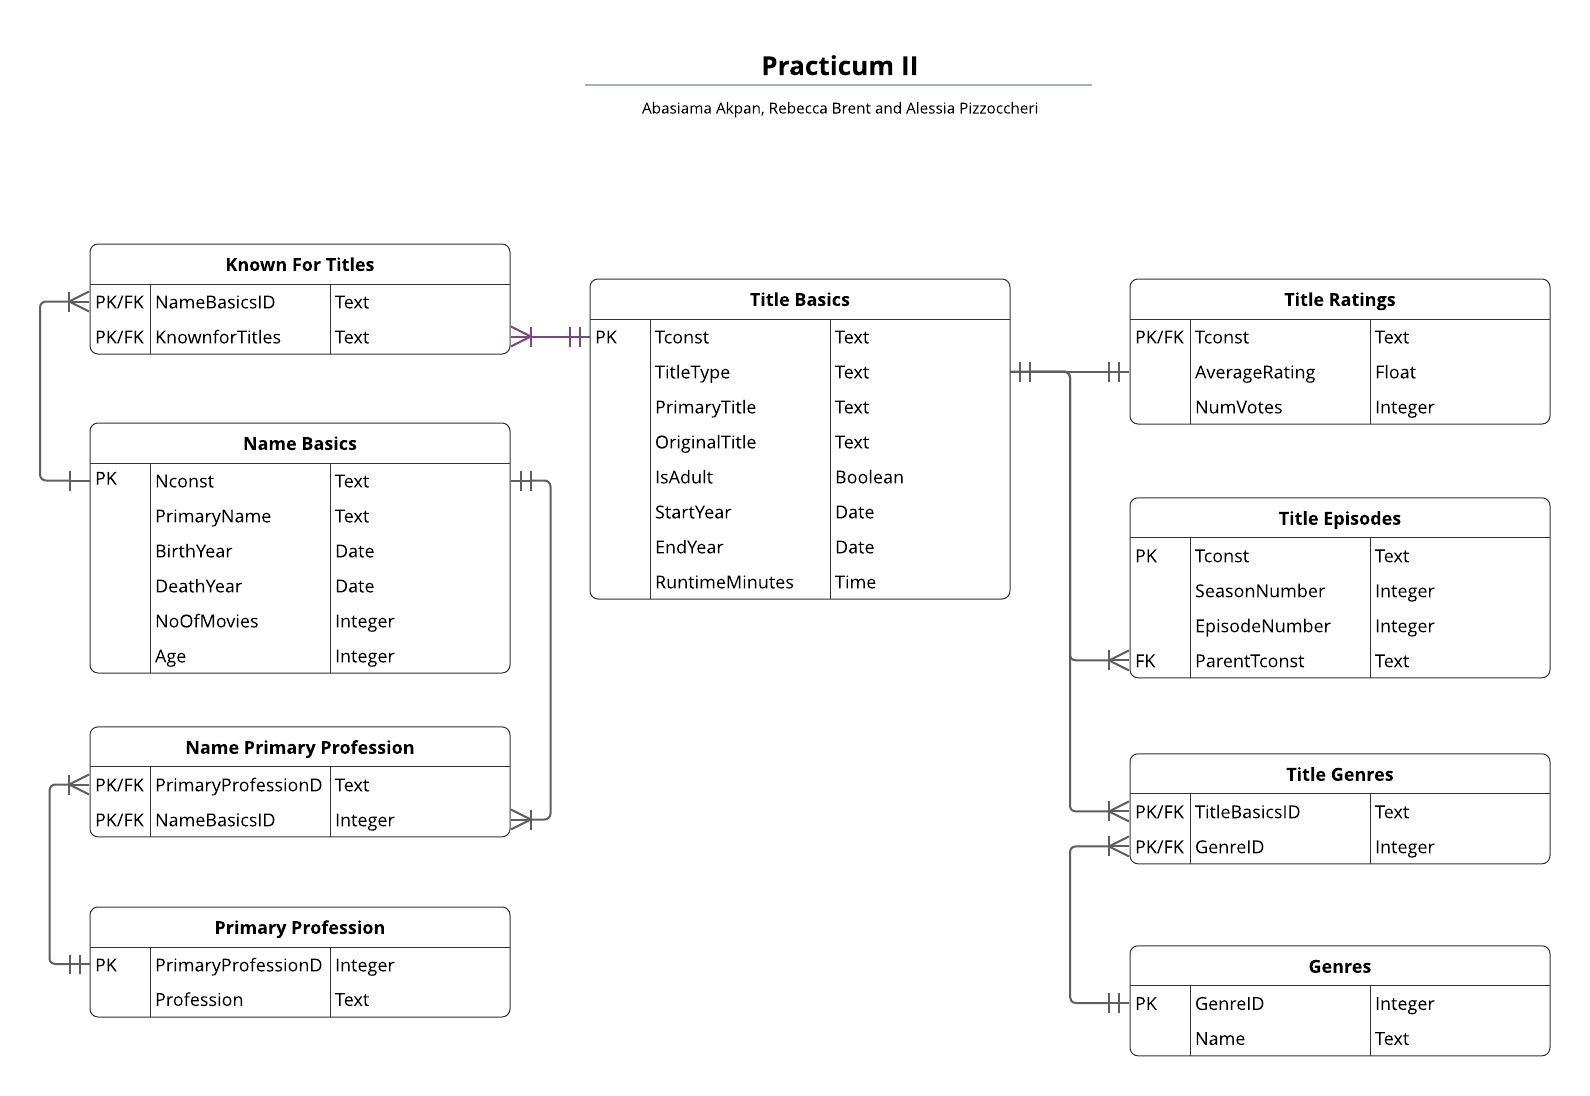

### 2. Parsing and Importing the Data
#### 2.1 Installing libraries and creating the database
In the following section, we create the database, create the tables and add them to the database; to help with our task, we import a handful of libraries.

In [38]:
import pandas as pd
import numpy as np
import os
import sys
import pip

from tqdm import tqdm
import mysql.connector
from mysql.connector import Error

# install packages used below if not already installed -- not necessary to run this chunk if they are
pip.main(['install','prettytable'])
pip.main(['install','mysql-connector-python'])
pip.main(['install','tqdm'])
pip.main(['install','pymysql'])
pip.main(['install', 'tkinter'])

host_name = "localhost"
user_name = "root"
database = "imdb"
password = input("Please enter the password for connecting to SQL (root): ")

BATCH_SIZE = 10000

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Exception during reset or similar
Traceback (most recent call last):
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/dialects/mysql/base.py", line 2374, in do_rollback
    dbapi_connection.rollback()
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/mysql/connector/connection_cext.py", line 403, in rollback
    self._cmysql.rollback()
_mysql_connector.MySQLInterfaceError: Lost connection to MySQL server during query
ERROR: Exception during reset or si

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Exception during reset or similar
Traceback (most recent call last):
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/dialects/mysql/base.py", line 2374, in do_rollback
    dbapi_connection.rollback()
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/mysql/connector/connection_cext.py", line 403, in rollback
    self._cmysql.rollback()
_mysql_connector.MySQLInterfaceError: Lost connection to MySQL server during query


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


Please enter the password for connecting to SQL (root):  alupizzo92


In [39]:
def create_connection_nodb():
    """ create a connection to mysql host
    :param host_name: string host name (ie. "localhost")
    :param user_name: string username (ie. "root")
    :param user_password: string the password to connect to mysql
    :return: connection object
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password
        )
        print("Connection to MySQL DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

def create_database(connection):
    """ create a database 
    :param connection: Connection object
    :param db_name: name of database in form of string
    :return:
    """
    cursor = connection.cursor()
    try:
        query = "CREATE DATABASE IF NOT EXISTS " + database
        cursor.execute(query)
        print("Database created successfully")
    except Error as e:
        print(f"The error '{e}' occurred")
        
def create_connection():
    """ create a connection to the (possibly newly created) database
    :param host_name: string host name (ie. "localhost")
    :param user_name: string username (ie. "root")
    :param user_password: string the password to connect to mysql
    :param db_name: string name of database 
    :return: connection object
    """
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
        print("Connection to MySQL DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
        table_name = create_table_sql.split(" ")[5].split("(")[0]
        print("Successfully created table: " + table_name)
    except Error as e:
        print(e)
        
def main():
    
    create_table_titlebasics = """CREATE TABLE IF NOT EXISTS titlebasics(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    titleType TEXT,
                                    primaryTitle MEDIUMTEXT,
                                    originalTitle MEDIUMTEXT,
                                    isAdult BOOLEAN,
                                    startYear DATE,
                                    endYear DATE,
                                    runTimeMinutes TIME)"""
    
    create_table_titleratings = """CREATE TABLE IF NOT EXISTS titleratings(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    averageRating FLOAT,
                                    numVotes INT,
                                    FOREIGN KEY (tconst) REFERENCES titlebasics(tconst))"""


    create_table_titleepisodes = """CREATE TABLE IF NOT EXISTS titleepisodes(
                                    tconst VARCHAR(11) PRIMARY KEY,
                                    seasonNumber INT,
                                    episodeNumber INT,
                                    parentTconst VARCHAR(11),
                                    FOREIGN KEY (parentTconst) REFERENCES titlebasics(tconst))"""


    create_table_namebasics = """CREATE TABLE IF NOT EXISTS namebasics(
                                nconst VARCHAR(11) PRIMARY KEY,
                                primaryname TEXT,
                                birthyear DATE,
                                deathyear DATE,
                                noofmovies INT,
                                age INT)"""
    
    
    create_table_genres = """CREATE TABLE IF NOT EXISTS genres(
                                genreID INT AUTO_INCREMENT  PRIMARY KEY,
                                genre VARCHAR(256) UNIQUE)"""
    
    create_table_primaryprofession = """CREATE TABLE IF NOT EXISTS primaryprofession(
                                primaryprofessionID INT AUTO_INCREMENT PRIMARY KEY,
                                profession VARCHAR(256) UNIQUE)"""
    
 
    
    
    create_table_genretitlebasics = """CREATE TABLE IF NOT EXISTS genretitlebasics(
                                titlebasicsID VARCHAR(11),
                                genreID INT,
                                PRIMARY KEY (titlebasicsID, genreID),
                                FOREIGN KEY (titlebasicsID) REFERENCES titlebasics(tconst),
                                FOREIGN KEY (genreID) REFERENCES genres(genreID))"""
    

    
    create_table_primaryprofessiontitlenames = """CREATE TABLE IF NOT EXISTS primaryprofessiontitlenames(
                                primaryprofessionid INT,
                                namebasicsid VARCHAR(11),
                                PRIMARY KEY (primaryprofessionid, namebasicsid),
                                FOREIGN KEY (primaryprofessionid) REFERENCES primaryprofession(primaryprofessionid),
                                FOREIGN KEY (namebasicsid) REFERENCES namebasics(nconst))"""
    
    create_table_knownfortitles = """CREATE TABLE IF NOT EXISTS knownfortitles(
                                namebasicsid VARCHAR(11),
                                knownfortitle VARCHAR(11),
                                PRIMARY KEY (namebasicsid, knownfortitle),
                                FOREIGN KEY (namebasicsid) REFERENCES namebasics(nconst),
                                FOREIGN KEY (knownfortitle) REFERENCES titlebasics(tconst))"""
    
    
    conn = create_connection_nodb()
    
    # create database object if not already created and then connect the cursor to it
    if conn is not None:
        create_database(conn)
        conn = create_connection()
        
        # create tables
        if conn is not None:
            
            # create Title Basics table
            create_table(conn, create_table_titlebasics)

            # create Title Ratings table
            create_table(conn, create_table_titleratings)
            
            # create title episodes table
            create_table(conn, create_table_titleepisodes)
            
            # create name basics table
            create_table(conn, create_table_namebasics)
            
            # create genres table
            create_table(conn,create_table_genres)
            
            # create known for titles table
            create_table(conn,create_table_knownfortitles)
            
            # create primary profession table
            create_table(conn,create_table_primaryprofession)
            
            # create genre title basics table
            create_table(conn, create_table_genretitlebasics)

            # create Primary Profession Title Names table
            create_table(conn, create_table_primaryprofessiontitlenames)
            
                
        else:
            print("Error! cannot create the database connection.")
    
    else:
        print("Error! Cannot create the MySQL connection.")

if __name__ == '__main__':
    main()

Connection to MySQL DB successful
Database created successfully
Connection to MySQL DB successful
Successfully created table: titlebasics
Successfully created table: titleratings
Successfully created table: titleepisodes
Successfully created table: namebasics
Successfully created table: genres
Successfully created table: knownfortitles
Successfully created table: primaryprofession
Successfully created table: genretitlebasics
Successfully created table: primaryprofessiontitlenames


#### 2.2 Import SQL communication helper

In [40]:
import sqlalchemy
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(user_name, password, 
                                                      host_name, database))

# define helper function
def load_dataframe(data_frame,table_name):
    data_frame_new=data_frame
    
    data_frame_new.to_sql(table_name,con=database_connection, if_exists='append',index=False)
    
    return 

# define helper function
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# define helper function
def preprocess_dataframe_parsing(data_frame, column_name, final_column_name):
    
    data_frame=data_frame.to_frame()
    data_frame=data_frame.assign(name=data_frame[column_name].str.split(","))
    #type(x.iloc[0,1])
    data_frame=data_frame.explode('name')
    data_preprocessed_unique= pd.DataFrame(data_frame.name.unique())
    data_preprocessed_unique_column_rename=data_preprocessed_unique.rename(columns={0:final_column_name})
    
    return data_preprocessed_unique_column_rename

In [54]:
from prettytable import PrettyTable

conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()

#### 2.3 Import Title Basics

In [5]:
# read title basic file
title_basics = pd.read_csv('title.basics.tsv', delimiter='\t', encoding='utf-8', low_memory=False)

In [6]:
def preprocess_dataframe_title_basics(data_frame):
    title_basics_new_series=data_frame

    b = pd.to_datetime(title_basics_new_series['runtimeMinutes'], errors='coerce', format='%M')

    b.to_frame().runtimeMinutes
    df_1 = pd.DataFrame(dict(time_stamps = b)) 

    df_1['runtimeMinutes'] = df_1['time_stamps'].dt.minute
    title_basics_new_series=title_basics_new_series.drop(['runtimeMinutes'],axis=1)
    title_basics_new_series['runtimeMinutes']=df_1['runtimeMinutes']
    
    title_basics_new_frame_transpose=title_basics_new_series.astype({'isAdult': 'int32'})
    
    title_basics_new_frame_transpose["isAdult"]=title_basics_new_frame_transpose.isAdult.mask(title_basics_new_frame_transpose.isAdult > 1,1)

    title_basics_new_frame_transpose['startYear']= pd.to_datetime(title_basics.startYear, errors='coerce', format='%Y')

    
    title_basics_new_frame_transpose['endYear']= pd.to_datetime(title_basics.endYear, errors='coerce', format='%Y')
    title_basics_new_frame_transpose=title_basics_new_frame_transpose.drop(['genres'],axis=1)
  

    title_basics_new_frame_transpose_new=title_basics_new_frame_transpose.rename(columns={"runtimeMinutes": "runTimeMinutes"})

    return title_basics_new_frame_transpose_new

title_basics_preprocessed=preprocess_dataframe_title_basics(title_basics)

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [7]:
length = len(title_basics_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_basics_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titlebasics')

100%|██████████| 731/731 [03:45<00:00,  3.25it/s]


In [8]:
genres_preprocessed = preprocess_dataframe_parsing(title_basics.genres, "genres", "genre")
genres_preprocessed.dropna(inplace=True)
genres_preprocessed = genres_preprocessed[genres_preprocessed.genre != '\\N']

In [9]:
length = len(genres_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(genres_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'genres')

100%|██████████| 1/1 [00:00<00:00, 186.53it/s]


In [10]:
# Create dictionary of genres with their id for mapping the genres in the association table
conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()
c.execute("SELECT * FROM genres")
records = c.fetchall()
genre_dict = {}
for row in records:
    genre_dict.update({row[1]:row[0]})
c.close()
conn.close()

In [11]:
def preprocess_dataframe__for_genres(data_frame):
    df = data_frame
    lst_col = 'genres'
  
    df = df.drop(['titleType'], axis=1)
    df = df.drop(['primaryTitle'], axis=1)
    df = df.drop(['originalTitle'], axis=1)
    df=df.drop(['isAdult'], axis=1)
    df=df.drop(['startYear'], axis=1)
    df=df.drop(['endYear'], axis=1)
    df=df.drop(['runtimeMinutes'],axis=1)
    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    genres_df = x.explode('genres')

    return genres_df

df =  preprocess_dataframe__for_genres(title_basics)
df = df[df.genres != '\\N']
df = df.replace({"genres":genre_dict})
df = df.rename(columns={"tconst" : "titlebasicsID", "genres" : "genreID"})

In [12]:
df.dropna(inplace=True)
#df
length = len(df)//BATCH_SIZE+1

for chunk in tqdm(batch(df, BATCH_SIZE), total=length):
    load_dataframe(chunk, 'genretitlebasics')

100%|██████████| 1103/1103 [04:07<00:00,  4.46it/s]


In [13]:
del df
del title_basics
del genres_preprocessed
del genre_dict
# title_basics_preprocessed is used later on so will not delete until after

In [20]:
def retrieve_genres():
    
    genres = pd.read_sql("""SELECT * FROM genres LIMIT 10;;""",database_connection.connect())
    
    return genres

# call function
retrieve_genres()

,genreID,genre
0,7,Action
1,28,Adult
2,18,Adventure
3,3,Animation
4,12,Biography
5,4,Comedy
6,15,Crime
7,1,Documentary
8,9,Drama
9,17,Family


In [19]:
def retrieve_genre_title_basics():
    
    genretitlebasics = pd.read_sql("""SELECT * FROM genretitlebasics LIMIT 10;;""",database_connection.connect())
    
    return genretitlebasics

# call function
retrieve_genre_title_basics()

,titlebasicsID,genreID
0,tt0000001,1
1,tt0000008,1
2,tt0000010,1
3,tt0000011,1
4,tt0000012,1
5,tt0000013,1
6,tt0000016,1
7,tt0000017,1
8,tt0000020,1
9,tt0000022,1


In [18]:
def retrieve_title_basics():
    
    titlebasics = pd.read_sql("""SELECT tconst, primaryTitle FROM titlebasics LIMIT 10;;""",database_connection.connect())
    
    return titlebasics

# call function
retrieve_title_basics()

,tconst,primaryTitle
0,tt0000001,Carmencita
1,tt0000002,Le clown et ses chiens
2,tt0000003,Pauvre Pierrot
3,tt0000004,Un bon bock
4,tt0000005,Blacksmith Scene
5,tt0000006,Chinese Opium Den
6,tt0000007,Corbett and Courtney Before the Kinetograph
7,tt0000008,Edison Kinetoscopic Record of a Sneeze
8,tt0000009,Miss Jerry
9,tt0000010,Leaving the Factory


#### 2.4 Import Title Ratings

In [19]:
# read data from title ratings file
title_ratings = pd.read_csv('title.ratings.tsv', nrows=250000, delimiter='\t',encoding='utf-8')

In [20]:
def preprocess_dataframe_title_ratings(data_frame):
    title_ratings_new_series=data_frame
    
    title_ratings_new_frame_avg_rating= title_ratings_new_series.astype({'averageRating': 'float'})
    title_ratings_new_frame_avg_rating= title_ratings_new_series.astype({'numVotes': 'int32'})
    #title_ratings_preprocessed.tconst = title_ratings_preprocessed.tconst.mask(~title_ratings_preprocessed.tconst.isin(title_basics_preprocessed.tconst),None)
    return title_ratings_new_frame_avg_rating

title_ratings_preprocessed=preprocess_dataframe_title_ratings(title_ratings)

In [21]:
length = len(title_ratings_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_ratings_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titleratings')

 96%|█████████▌| 25/26 [00:05<00:00,  4.64it/s]


In [22]:
# delete now unrequired tables to free memory
del title_ratings
del title_ratings_preprocessed

In [14]:
def retrieve_title_ratings():
    
    titleratings = pd.read_sql("""SELECT tconst, averageRating FROM titleratings LIMIT 10;""",database_connection.connect())
    
    return titleratings

# call function
retrieve_title_ratings()

,tconst,averageRating
0,tt0000001,5.6
1,tt0000002,6.1
2,tt0000003,6.5
3,tt0000004,6.2
4,tt0000005,6.2
5,tt0000006,5.3
6,tt0000007,5.4
7,tt0000008,5.4
8,tt0000009,5.9
9,tt0000010,6.9


#### 2.5 Import Title Episodes

In [25]:
# read title episodes data
title_episodes = pd.read_csv('title.episode.tsv', delimiter='\t',encoding='utf-8')

In [26]:
def preprocess_dataframe_title_episodes(data_frame):
    title_episodes_new_series=data_frame
    title_episodes_coerce_seasonNum = pd.to_numeric(title_episodes_new_series['seasonNumber'], errors='coerce')
    title_episodes_coerce_episodeNum = pd.to_numeric(title_episodes_new_series['episodeNumber'], errors='coerce')

    df_1 = pd.DataFrame(dict(test_column_1 = title_episodes_coerce_seasonNum)) 
    df_2 = pd.DataFrame(dict(test_column_2 = title_episodes_coerce_episodeNum)) 

    df_1['seasonNumber'] = df_1['test_column_1']
    df_2['episodeNumber'] = df_2['test_column_2']
    
    title_episodes_new_frame=title_episodes_new_series.drop(['seasonNumber'],axis=1)
    title_episodes_new_frame=title_episodes_new_series.drop(['episodeNumber'],axis=1)
    
    title_episodes_new_frame['seasonNumber']=df_1['seasonNumber']
    title_episodes_new_frame['episodeNumber']=df_2['episodeNumber']
    return title_episodes_new_frame

title_episodes_preprocessed = preprocess_dataframe_title_episodes(title_episodes)

# removes any episodes that do not have a corresponding key in title basics table 
title_episodes_preprocessed=title_episodes_preprocessed[
    title_episodes_preprocessed.parentTconst.isin(title_basics_preprocessed.tconst)]

In [27]:
# load dataframe into corresponding SQL table
length = len(title_episodes_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(title_episodes_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'titleepisodes')

100%|██████████| 527/527 [03:12<00:00,  2.74it/s]


In [28]:
del title_episodes_preprocessed
del title_episodes

In [13]:
def retrieve_title_episodes():
    
    titleepisodes = pd.read_sql("""SELECT tconst, seasonNumber, episodeNumber, parentTconst FROM titleepisodes LIMIT 10;""",database_connection.connect())
    
    return titleepisodes

# call function
retrieve_title_episodes()

,tconst,seasonNumber,episodeNumber,parentTconst
0,tt0041951,1.0,9.0,tt0041038
1,tt0042816,1.0,17.0,tt0989125
2,tt0042889,NaN,NaN,tt0989125
3,tt0043426,3.0,42.0,tt0040051
4,tt0043631,2.0,16.0,tt0989125
5,tt0043693,2.0,8.0,tt0989125
6,tt0043710,3.0,3.0,tt0989125
7,tt0044093,1.0,6.0,tt0959862
8,tt0044668,2.0,16.0,tt0044243
9,tt0044901,3.0,46.0,tt0989125


#### 2.6 Import Name Basics

In [37]:
name_basics = pd.read_csv('name.basics.tsv', delimiter='\t', encoding='utf-8')

In [38]:
def preprocess_dataframe_name_basics(data_frame):
    name_basics_new_series=data_frame
    name_basics_new_series=name_basics_new_series.drop(['primaryProfession', 'knownForTitles'],axis=1)
    
    name_basics_new_series['birthYear']= pd.to_datetime(name_basics_new_series.birthYear, errors='coerce', format='%Y')

    
    name_basics_new_series['deathYear']= pd.to_datetime(name_basics_new_series.deathYear, errors='coerce', format='%Y')
    
    return name_basics_new_series

name_basics_preprocessed = preprocess_dataframe_name_basics(name_basics)

name_basics_preprocessed["noofmovies"] = ""
name_basics_preprocessed["age"] = ""

name_basics_preprocessed_new= pd.to_numeric(name_basics_preprocessed['noofmovies'], errors='coerce')
name_basics_preprocessed_new = pd.to_numeric(name_basics_preprocessed['age'], errors='coerce')

df_1 = pd.DataFrame(dict(test_column_1 = name_basics_preprocessed_new)) 
df_2 = pd.DataFrame(dict(test_column_2 = name_basics_preprocessed_new)) 

df_1['noofmovies'] = df_1['test_column_1']
df_2['age'] = df_2['test_column_2']

name_basics_preprocessed['noofmovies']=df_1['noofmovies']
name_basics_preprocessed['age']=df_2['age']

del df_1
del df_2

In [39]:
# load dataframe into corresponding SQL table
length = len(name_basics_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(name_basics_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(chunk,'namebasics')

100%|██████████| 1048/1048 [03:54<00:00,  4.46it/s]


In [40]:
profession_preprocessed=preprocess_dataframe_parsing(name_basics.primaryProfession, "primaryProfession", "profession")
profession_preprocessed.dropna(inplace=True)

In [41]:
# load dataframe into corresponding SQL table
length = len(profession_preprocessed)//BATCH_SIZE+1

for chunk in tqdm(batch(profession_preprocessed,BATCH_SIZE),total=length):
    load_dataframe(profession_preprocessed,'primaryprofession')

100%|██████████| 1/1 [00:00<00:00, 127.33it/s]


In [42]:
# Create dictionary of professions with their id for mapping the professions in the association table
conn = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=password,
            database=database
        )
c = conn.cursor()
c.execute("SELECT * FROM primaryprofession")
records = c.fetchall()
prof_dict = {}
for row in records:
    prof_dict.update({row[1]:row[0]})
c.close()
conn.close()

In [11]:
def retrieve_primary_profession():
    
    primaryprofession = pd.read_sql("""SELECT primaryprofessionid, profession FROM primaryprofession LIMIT 10;""",database_connection.connect())
    
    return primaryprofession

# call function
retrieve_primary_profession()

,primaryprofessionid,profession
0,2,actor
1,4,actress
2,21,animation_department
3,22,art_department
4,17,art_director
5,38,assistant
6,11,assistant_director
7,12,camera_department
8,29,casting_department
9,15,casting_director


In [43]:
def preprocess_dataframe_for_primaryprof(data_frame):
    df = data_frame
    lst_col = 'primaryProfession'
  
    df = df.drop(['primaryName'], axis=1)
    df = df.drop(['birthYear'], axis=1)
    df = df.drop(['deathYear'], axis=1)
    df=df.drop(['knownForTitles'], axis=1)

    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    primaryprof_df = x.explode('primaryProfession')

    return primaryprof_df

df =  preprocess_dataframe_for_primaryprof(name_basics)

df=df[df.primaryProfession.isin(profession_preprocessed.profession)]
df.dropna(inplace=True)
df = df.replace({"primaryProfession":prof_dict})
# delete dictionary because no longer needed
del prof_dict
# rename columns to match the SQL variables for loading
df = df.rename(columns={"nconst" : "namebasicsID", "primaryProfession" : "primaryprofessionID"})

In [46]:
# load dataframe into corresponding SQL table
length = len(df)//BATCH_SIZE+1

for chunk in tqdm(batch(df,BATCH_SIZE),total=length):
    load_dataframe(chunk,'primaryprofessiontitlenames')

100%|██████████| 1144/1144 [04:23<00:00,  4.34it/s]


In [10]:
def retrieve_primary_profession_title_names():
    
    primaryprofessiontitlenames = pd.read_sql("""SELECT primaryprofessionid, namebasicsid FROM primaryprofessiontitlenames LIMIT 10;""",database_connection.connect())
    
    return primaryprofessiontitlenames

# call function
retrieve_primary_profession_title_names()

,primaryprofessionid,namebasicsid
0,1,nm0000001
1,2,nm0000001
2,3,nm0000001
3,1,nm0000002
4,4,nm0000002
5,1,nm0000003
6,4,nm0000003
7,5,nm0000003
8,1,nm0000004
9,2,nm0000004


In [48]:
def preprocess_dataframe_for_knownfortitles(data_frame):
    df = data_frame
    lst_col = 'knownForTitles'
  
    df = df.drop(['primaryName'], axis=1)
    df = df.drop(['birthYear'], axis=1)
    df = df.drop(['deathYear'], axis=1)
    df=df.drop(['primaryProfession'], axis=1)
    
    x = df.assign(**{lst_col:df[lst_col].str.split(',')})
    kft_df = pd.DataFrame({
                      col:np.repeat(x[col].values, x[lst_col].str.len())
                      for col in x.columns.difference([lst_col])
                      }).assign(**{lst_col:np.concatenate(x[lst_col].values)})[x.columns.tolist()]

    return kft_df

kft_df =  preprocess_dataframe_for_knownfortitles(name_basics)


kft_df = kft_df[kft_df.knownForTitles != '\\N']
kft_df=kft_df[kft_df.knownForTitles.isin(title_basics_preprocessed.tconst)]
kft_df = kft_df.rename(columns={"nconst" : "namebasicsID", "knownForTitles" : "knownfortitle"})

In [49]:
# load dataframe into corresponding SQL table
length = len(kft_df)//BATCH_SIZE+1

for chunk in tqdm(batch(kft_df,BATCH_SIZE),total=length):
    load_dataframe(chunk,'knownfortitles')

100%|██████████| 1644/1644 [16:40<00:00,  1.64it/s]


In [42]:
# delete all dataframes out of memory since all information is now in SQL DB Tables
del kft_df
del df
del name_basics_preprocessed
del title_basics_preprocessed

In [9]:
def retrieve_name_basics():
    
    namebasics = pd.read_sql("""SELECT nconst, primaryName FROM namebasics LIMIT 10;""",database_connection.connect())
    
    return namebasics

# call function
retrieve_name_basics()

,nconst,primaryName
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman
5,nm0000006,Ingrid Bergman
6,nm0000007,Humphrey Bogart
7,nm0000008,Marlon Brando
8,nm0000009,Richard Burton
9,nm0000010,James Cagney


### 3. Procedures and Triggers
In this section we defined a set of queries to update records on the _Name Basics_ table; specifically we want to calculate and insert values on the two columns we have added to the table schema, specifically: `age` and `noofmovies`.

#### 3.1. Updating existing records
We use the query below to update the _Name Basics_ table and insert values into the _Age_ and _Number of movies_ columns; to do so we create two store procedures. To calculate the age we call `calculate_age()` on each row, check if a date of death if defined and calculate the age accordingly. The store procedure is defined as follow:
```
DROP PROCEDURE IF EXISTS calculate_age;
delimiter //
CREATE PROCEDURE calculate_age()

BEGIN

    DECLARE _nconst VARCHAR(11);
    DECLARE _deathyear DATE;
    DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

    open cur;
    myloop:LOOP
        fetch cur into _nconst;
        IF (SELECT deathyear FROM namebasics WHERE nconst = _nconst) IS NULL THEN
            UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, CURDATE()) WHERE nconst = _nconst;
        ELSE
            UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, deathyear) WHERE nconst = _nconst;
        END IF;

    end loop myloop;
    close cur;


END //
delimiter ;

CALL calculate_age();
UPDATE namebasics SET age = calculate_age();
```

In [9]:
conn = create_connection()
c = conn.cursor()

operation = """DROP PROCEDURE IF EXISTS calculate_age;
            delimiter //
            CREATE PROCEDURE calculate_age()

            BEGIN

                DECLARE _nconst VARCHAR(11);
                DECLARE _deathyear DATE;
                DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

                open cur;
                myloop:LOOP
                    fetch cur into _nconst;
                    IF (SELECT deathyear FROM namebasics WHERE nconst = _nconst) IS NULL THEN
                        UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, CURDATE()) WHERE nconst = _nconst;
                    ELSE
                        UPDATE namebasics SET age = TIMESTAMPDIFF(YEAR, birthyear, deathyear) WHERE nconst = _nconst;
                    END IF;

                end loop myloop;
                close cur;


            END //
            delimiter ;
            
            CALL calculate_age();
            UPDATE namebasics SET age = calculate_age();"""

c.execute(query)

Connection to MySQL DB successful


To calculate the number of movies each actor/actress has appeared in, we call `calculate_noofmovies()` on each row, we cross reference the `titlebasics` and `knownfortitles` tables and calculate the number of movies associated with each person. The store procedure is defined as follow:
```
DROP PROCEDURE IF EXISTS calculate_noofmovies;
delimiter //
CREATE PROCEDURE calculate_noofmovies()
BEGIN
    DECLARE _nconst VARCHAR(11);
    DECLARE cur CURSOR FOR SELECT nconst FROM namebasics;

    open cur;
    myloop:LOOP
        fetch cur into _nconst;
        UPDATE namebasics SET noofmovies = (
                SELECT COUNT(*) FROM (SELECT * FROM knownfortitles AS KT
                INNER JOIN titlebasics AS TB ON KT.knownfortitle = TB.tconst
                WHERE TB.titletype = 'Movie') AS results
                WHERE results.namebasicsID = _nconst);
    end loop myloop;
    close cur;
END //
delimiter ;

CALL calculate_noofmovies();
UPDATE namebasics SET noofmovies = calculate_noofmovies();
```


We can now print a small sample of set from the _Name Basics_ table to show the updated records.

In [35]:
def retrieve_name_basics_age():
    
    namebasics = pd.read_sql("""SELECT * FROM namebasics AS NB LIMIT 5;""",database_connection.connect())
    
    return namebasics

# call function
retrieve_name_basics_age()

,nconst,primaryname,birthyear,deathyear,noofmovies,age
0,nm0000001,Fred Astaire,1899-01-01,1987-01-01,4,88
1,nm0000002,Lauren Bacall,1924-01-01,2014-01-01,4,90
2,nm0000003,Brigitte Bardot,1934-01-01,None,4,86
3,nm0000004,John Belushi,1949-01-01,1982-01-01,3,33
4,nm0000005,Ingmar Bergman,1918-01-01,2007-01-01,4,89


#### 3.2 Adding triggers
In this section, we create two triggers to ensure _Age_ and _Number of Movies_ are properly updated whenever a new record is added to the _Name Basics_ table. The `namebasics_calc_age` which calculates the actor/actress age, is defined as follows:
```
DROP TRIGGER IF EXISTS namebasics_calc_age;
delimiter //
CREATE TRIGGER namebasics_calc_age BEFORE INSERT ON namebasics
    FOR EACH ROW
        BEGIN
            IF NEW.deathyear IS NULL THEN
                SET NEW.age = TIMESTAMPDIFF(YEAR, NEW.birthyear, CURDATE());
            ELSE
                SET NEW.age = TIMESTAMPDIFF(YEAR, NEW.birthyear, NEW.deathyear);
            END IF;
    END //
delimiter ;
```
While, the `namebasics_calc_no_movies` used to calculate the number of movies an actor/actress has appeared in is defined as such:
```
DROP TRIGGER IF EXISTS namebasics_calc_no_movies;
delimiter //
CREATE TRIGGER namebasics_calc_no_movies BEFORE INSERT ON namebasics
    FOR EACH ROW
        BEGIN
            # placeholder until data is available
            SET NEW.noofmovies = (
                SELECT COUNT(*) FROM (SELECT * FROM knownfortitles AS KT
                INNER JOIN titlebasics AS TB ON KT.knownfortitle = TB.tconst
                WHERE TB.titletype = 'Movie') AS results
                WHERE results.namebasicsID = _nconst);
END //
delimiter ;
```

In [36]:
conn = create_connection()
c = conn.cursor()

query = """INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
        VALUES ('nm9999900', 'Emma Stone', '1988-11-06', NULL, NULL, NULL);"""
c.execute(query)

Connection to MySQL DB successful


In [43]:
def add_new_actress():
    
    new_actress = pd.read_sql("""SELECT * FROM namebasics AS N
        WHERE N.nconst = 'nm9999900';""",database_connection.connect())
    
    return new_actress

# call function
add_new_actress()

,nconst,primaryname,birthyear,deathyear,noofmovies,age
0,nm9999900,Emma Stone,1988-11-06,None,0,32


In [44]:
query = """DELETE FROM namebasics AS N
        WHERE N.nconst = 'nm9999900';"""

c.execute(query)

### 4. Views
In this section we create a new view to display the name of each actor or actress, their age, whether they are still alive or not, and how many movies they are known for; we do so by defining the following query:
```
DROP VIEW IF EXISTS actors_view;
CREATE VIEW actors_view AS SELECT primaryname, 
CASE
    WHEN deathyear IS NOT NULL THEN 
        TRUE
    ELSE
        FALSE 
END 
AS isalive, age, noofmovies FROM namebasics N
INNER JOIN primaryprofessiontitlenames PPTN on N.nconst = PPTN.namebasicsid 
INNER JOIN primaryprofession PP on PPTN.primaryprofessionid = PP.primaryprofessionid
WHERE PP.profession = "actress" or PP.profession = "actor";
```

If an actor or actress is alive, we assign value of `1` to the `isalive` column, otherwise we use `0`.

In [5]:
with database_connection.connect() as con:

    
        rs = con.execute("""DROP VIEW IF EXISTS actors_view;
                        CREATE VIEW actors_view AS SELECT primaryname,CASE WHEN deathyear IS NOT NULL
                        THEN TRUE ELSE FALSE END AS isalive,age,noofmovies FROM namebasics n
                        Inner Join primaryprofessiontitlenames pptn on n.nconst=pptn.namebasicsid 
                        Inner Join primaryprofession pp on pptn.primaryprofessionid=pp.primaryprofessionID 
                        WHERE pp.profession="actress" or pp.profession="actor";""")
        con.close()

ERROR: Exception during reset or similar
Traceback (most recent call last):
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/engine/base.py", line 774, in _commit_impl
    self.engine.dialect.do_commit(self.connection)
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/dialects/mysql/base.py", line 2362, in do_commit
    dbapi_connection.commit()
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/mysql/connector/connection_cext.py", line 397, in commit
    self._cmysql.commit()
_mysql_connector.MySQLInterfaceError: Commands out of sync; you can't run this command now

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/engine/base.py", line 752, in _rollback_impl
    self.engine.dialect.do_rollback(self.connection)
  File "/Users/apizzoccheri/opt/anaconda3/lib/python3.8/site-

DBAPIError: (_mysql_connector.MySQLInterfaceError) Commands out of sync; you can't run this command now
(Background on this error at: http://sqlalche.me/e/13/dbapi)

In [5]:
# with database_connection.connect() as con:
alive_or_dead_list = pd.read_sql('SELECT * FROM actors_view LIMIT 10', database_connection.connect())

In [6]:
alive_or_dead_list

,primaryname,isalive,age,noofmovies
0,Fred Astaire,1,88,None
1,John Belushi,1,33,None
2,Ingmar Bergman,1,89,None
3,Humphrey Bogart,1,58,None
4,Marlon Brando,1,80,None
5,Richard Burton,1,59,None
6,James Cagney,1,87,None
7,Gary Cooper,1,60,None
8,James Dean,1,24,None
9,Kirk Douglas,1,104,None


### 5. Queries
In this section we define a set of queries to retrieve different data sets from the database.

In this first query, we retrieve the number of seasons for each TV series; using the results of the query, we create a histogram to display our findings. The query is defined as follows:
```
SELECT TB.originaltitle, COUNT(DISTINCT(TE.seasonnumber)) AS noofseasons 
FROM titleepisodes AS TE 
INNER JOIN titlebasics tb ON TE.parenttconst = TB.tconst 
GROUP BY TB.originaltitle;   
```

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'NoOfSeasons'),
 Text(0.5, 1.0, 'NoOfSeasons Frequency')]

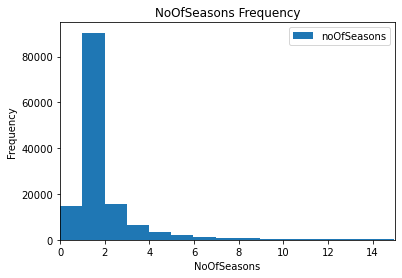

In [20]:
no_of_seasons = pd.read_sql("""SELECT tb.originalTitle, COUNT(DISTINCT(te.seasonNumber))
                 AS noOfSeasons FROM titleepisodes AS te 
                 INNER JOIN titlebasics tb ON te.parentTconst = tb.tconst 
                 GROUP BY tb.originalTitle;""", database_connection.connect())
no_of_seasons
no_of_seasons.describe()
no_of_seasons_plot=no_of_seasons.plot.hist(bins=268, xlim=(0,15))
no_of_seasons_plot.set(xlabel='NoOfSeasons', ylabel='Frequency', title='NoOfSeasons Frequency')

We now write another query to retrieve the names and ages of all actors who appeared in more than two movies, with the exception of TV Movies; the query is defined as follows:

```
SELECT DISTINCT subquery.primaryname, subquery.age FROM (
    SELECT primaryname, age, SUM(averagerating * numvotes) / SUM(numvotes) 
    AS avgrating from namebasics as NB
INNER JOIN knownfortitles KT on NB.nconst = KT.namebasicsid
INNER JOIN titlebasics TB on KT.knownfortitle = TB.tconst
INNER JOIN titleratings TR on TB.tconst = TR.tconst
WHERE TB.titletype = 'movie'
GROUP BY primaryName, age) AS subquery
WHERE avgRating > (SELECT SUM(averageRating*numVotes)/SUM(numVotes) FROM titleratings);  
```

In [45]:
def retrieveActorNames():
    
    actor_retrieve = pd.read_sql("""SELECT DISTINCT subquery.primaryName,subquery.age FROM (SELECT primaryName,age, SUM(averageRating*numVotes)/SUM(numVotes) AS avgRating from namebasics as nb
                                    INNER JOIN knownfortitles ktr on nb.nconst=ktr.namebasicsid
                                    INNER JOIN titlebasics tb on ktr.knownfortitle=tb.tconst
                                    INNER JOIN titleratings tr on tb.tconst=tr.tconst
                                    WHERE tb.titleType='movie'
                                    GROUP BY primaryName,age) AS subquery
                                    WHERE avgRating > (SELECT SUM(averageRating*numVotes)/SUM(numVotes) FROM titleratings) LIMIT 10;""",database_connection.connect())
    
    return actor_retrieve

# call function
retrieveActorNames()

,primaryName,age
0,L. Frank Baum,63.0
1,Will Morrison,NaN
2,William Gillespie,NaN
3,Kaj Rasmussen,NaN
4,Grigore Brezeanu,27.0
5,Victor De Bon,NaN
6,Lucia Sturza-Bulandra,88.0
7,Constantin Neamtu-Ottonel,NaN
8,Sydney Booth,64.0
9,Paul Franck,77.0


### 7. Functions
In this section we define two store procedures to perform the following actions: 
1. add an actor 
2. delete an actor

These two procedures are defined below.

#### 7.1 Adding an actor

```
DELIMITER $$
  CREATE PROCEDURE ADD_ACTOR(
        IN new_name_basics_string_id VARCHAR(11),
        IN new_title_basics_string_id VARCHAR(11),
        IN new_primary_profession_int_id INT,
        IN primaryName TEXT,
        IN profession VARCHAR(32),
        IN BirthYear TEXT,
        IN DeathYear TEXT,
        IN Age INT,
        IN NoofMovies INT,
        IN titletype TEXT,
        IN primarytitle MEDIUMTEXT,
        IN originaltitle MEDIUMTEXT,
        IN isAdult BOOLEAN,
        IN StartYear TEXT,
        IN EndYear TEXT,
        IN runTimeMinutes TIME,


    ) BEGIN
        START TRANSACTION;
        INSERT INTO namebasics (nconst, 
                                primaryname,
                                birthyear,
                                deathyear,
                                age,
                                noofmovies) 
            VALUES (new_name_basics_string_id,
                    primaryName, 
                    STR_TO_DATE(BirthYear,'%d-%m-%Y'), 
                    STR_TO_DATE(DeathYear,'%d-%m-%Y'),
                    Age,
                    NoofMovies);
        INSERT INTO titlebasics (tconst,
                                 titleType,
                                 primaryTitle,
                                 originalTitle,
                                 isAdult,
                                 startYear,
                                 endYear,
                                 runtimeMinutes)
            VALUES (new_title_basics_string_id,
                    titletype,
                    primarytitle,
                    originaltitle,
                    isAdult,
                    STR_TO_DATE(StartYear,'%d-%m-%Y'),
                    STR_TO_DATE(EndYear,'%d-%m-%Y'),
                    runTimeMinutes);
        INSERT INTO knownfortitles (namebasicsid,
                                    knownfortitle)
            VALUES(new_name_basics_string_id,
                   new_title_basics_string_id);
        INSERT INTO primaryprofessiontitlenames (primaryprofessionid,
                                                 namebasicsid)
            VALUES(new_primary_profession_int_id,
                   new_name_basics_string_id);
       COMMIT WORK;
    END$$
DELIMITER ;
```

#### 7.2 Deleting an actor

```
DELIMITER $$
    CREATE PROCEDURE DELETE_ACTOR(
            IN new_name_basics_string_id VARCHAR(11),
            IN new_title_basics_string_id VARCHAR(11),
            IN new_primary_profession_int_id INT,
            IN profession VARCHAR(32)

      ) BEGIN
        START TRANSACTION;
            DELETE FROM primaryprofessiontitlenames AS PPTN
            WHERE PPTN.primaryprofessionid = new_primary_profession_int_id;
            DELETE FROM primaryprofession AS PP
            WHERE PP.profession = profession;
            DELETE FROM knownfortitles AS KT 
            WHERE KT.knownfortitle = new_title_basics_string_id;
            DELETE FROM namebasics AS NB 
            WHERE NB.nconst = new_name_basics_string_id;
    COMMIT WORK;
    END$$
DELIMITER ;
```

#### 7.3 Defining helper functions
In order to add a new actor, we need to define a set of helper functions to help us create a unique primary key for all affected tables. We specifically need to generate a unique random string that can be used for the `tconst`, `nconst` and `primaryprofessionid` columns.
##### 7.3.1 Generate random string

In [22]:
import string
import random

def get_random_string(length):

    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

##### 7.3.2 Generate random nconst

In [23]:
def generate_nconst_string_id(table_name,length):
    
    table_id=set(table_name.nconst)
    #name_basicsid

    while True:
        new_id=get_random_string(length)
        if new_id not in table_id:
            return new_id

##### 7.3.3 Generate random tconst

In [24]:
def generate_tconst_string_id(table_name,length):
    
    table_id=set(table_name.tconst)
    #name_basicsid

    while True:
        new_id=get_random_string(length)
        if new_id not in table_id:
            return new_id

##### 7.3.4 Generate random primaryprofessionid

In [25]:
def generate_int_id(table):
    new_id=len(table)+20
    
    return new_id

In [26]:
new_id=generate_string_id(name_basics,7)
new_id

NameError: name 'generate_string_id' is not defined

In [ ]:
# DELIMITER $$
#           CREATE PROCEDURE ADD_ACTOR(
#                 IN new_name_basics_string_id VARCHAR(11),
#                 IN new_title_basics_string_id VARCHAR(11),
#                 IN new_primary_profession_int_id INT,
#                 IN primaryName TEXT,
#                 IN profession VARCHAR(32),
#                 IN BirthYear TEXT,
#                 IN DeathYear TEXT,
#                 IN Age INT,
#                 IN NoofMovies INT,
#                 IN titletype TEXT,
#                 IN primarytitle MEDIUMTEXT,
#                 IN originaltitle MEDIUMTEXT,
#                 IN isAdult BOOLEAN,
#                 IN StartYear TEXT,
#                 IN EndYear TEXT,
#                 IN runTimeMinutes TIME,


#             ) BEGIN
#                 START TRANSACTION;
#                 INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear,age,noofmovies) 
#                     VALUES (new_name_basics_string_id, primaryName, STR_TO_DATE(BirthYear,'%d-%m-%Y'), STR_TO_DATE(DeathYear,'%d-%m-%Y'),Age,NoofMovies);
#                 INSERT INTO titlebasics (tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes)
#                     VALUES (new_title_basics_string_id,titletype,primarytitle,originaltitle,isAdult,STR_TO_DATE(StartYear,'%d-%m-%Y'),STR_TO_DATE(EndYear,'%d-%m-%Y'),runTimeMinutes);
#                 INSERT INTO knownfortitles (namebasicsid,knownfortitle)
#                     VALUES(new_name_basics_string_id,new_title_basics_string_id);
#                 INSERT INTO primaryprofessiontitlenames (primaryprofessionid,namebasicsid)
#                     VALUES(new_primary_profession_int_id,new_name_basics_string_id);
#                COMMIT WORK;
#             END$$
#     DELIMITER ;


#### 7.4 Executing the functions

In [27]:
new_name_basics_string_id=generate_nconst_string_id(name_basics,7)
new_title_basics_string_id=generate_tconst_string_id(title_basics,7)

NameError: name 'name_basics' is not defined

In [ ]:
def addActor(primaryName,profession,BirthYear,DeathYear,Age,NoOfMovies,titletype,primarytitle,originaltitle,isAdult,StartYear,EndYear,runtimeMinutes):

    new_primary_profession_int_id=2 #2 is actor id in primaryprofession table

    
    with database_connection.connect() as con:

        query_string=f"""CALL ADD_ACTOR('{new_name_basics_string_id}','{new_title_basics_string_id}','{new_primary_profession_int_id}','{primaryName}','{profession}','{BirthYear}','{DeathYear}','{Age}','{NoOfMovies}','{titletype}','{primarytitle}','{originaltitle}','{isAdult}','{StartYear}','{EndYear}','{runtimeMinutes}')"""


        actor_added = pd.read_sql(query_string,con)


    return actoradded


### ACTOR WAS ADDED-IGNORE THE ERROR. CALL STORED PROCEDURE DOES NOT RETURN ROWS HENCE THE ERROR

In [28]:
new_actor=addActor("RippleEffect","actor",'01-01-1993','29-06-2018',25,600,"FerrisMovieType","FerrisPrimaryMovieTitle","FerrisMovieOrginalTitle",0,"19-05-2004","09-05-2005",103)

NameError: name 'addActor' is not defined

In [ ]:
new_actor_added = pd.read_sql(f"""SELECT * FROM namebasics WHERE primaryName='RippleEffect'""", database_connection.connect())

In [ ]:
new_actor_added

In [ ]:
#from IPython.display import Image
#Image(filename='actor.png')

## QUESTION 10-Same Structure as 9

In [ ]:
#   DELIMITER $$
#         CREATE PROCEDURE DELETE_ACTOR(
# 				IN new_name_basics_string_id VARCHAR(11),
# 				IN new_title_basics_string_id VARCHAR(11),
# 				IN new_primary_profession_int_id INT,
# 				IN profession VARCHAR(32)

#           ) BEGIN
#   			START TRANSACTION;
# 				DELETE FROM primaryprofessiontitlenames WHERE primaryprofessiontitlenames.primaryprofessionid=new_primary_profession_int_id;
#   				DELETE FROM primaryprofession WHERE primaryprofession.profession=profession;
#   				DELETE FROM knownfortitles WHERE knownfortitles.knownfortitle=new_title_basics_string_id;
#   				DELETE FROM namebasics WHERE namebasics.nconst=new_name_basics_string_id;
#  	COMMIT WORK;
#   	END$$
#   DELIMITER ;

In [ ]:
def deleteActor(nbid,tbid):
    new_primary_profession_int_id=2
    cast_type='actor'


    with database_connection.connect() as con:



        query_string=f"""CALL DELETE_ACTOR('{nbid}','{tbid}','{new_primary_profession_int_id}','{cast_type}')"""
    
        actor_added = pd.read_sql(query_string,con)


    
    return actor_added

In [ ]:
deleteActor(new_name_basics_string_id,new_title_basics_string_id)

In [ ]:
new_actor_deleted = pd.read_sql(f"""SELECT * FROM namebasics WHERE primaryName='RippleEffect'""", database_connection.connect())
new_actor_deleted

### 7. Indexes
In this section, we defined, run and observe a set of indexes on numerous tables to determine how performance is affected when performing retrieval and insertion on the updated table.

#### 7.1 Retrieving a record from Name Basics
We write a query to find an actor by name, then measure the execution time of the query. We then create an index that would improve the performance of the query and run the same query and compare execution time. In the graph below, we illustrate a comparison of the performance of the query before the index was added and after; we can observe that by adding an index on the `primaryname` column, retrieval time declines by 44.72%.
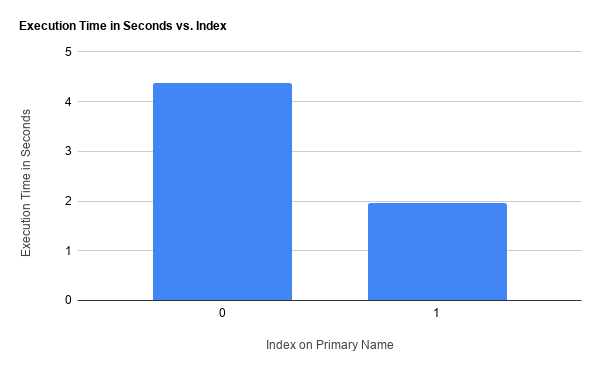

In [ ]:
# query = """SELECT primaryname FROM namebasics AS NB
# WHERE NB.primaryname = 'Romeo del Rosario';"""

# c.execute(query)

# query = """CREATE INDEX idx_primaryname
# ON namebasics (primaryname(288));"""

# c.execute(query)

# query = """SELECT primaryname FROM namebasics AS NB
# WHERE NB.primaryname = 'Romeo del Rosario';"""

# c.execute(query)

#### 7.1 Insertion Performance
In this section, we evaluate insertion performance when multiple indexes are added to the same table. We have already created a new index on the `namebasics` table, specifically `idx_primaryname`. We now create three additional indexes:
1. Index on `nconst`;
2. Index on `birthyear`;
2. Index on `age`;

We now proceed to insert a new record after each new index is created and compare insertion performance; our findings are presented in the line chart below.
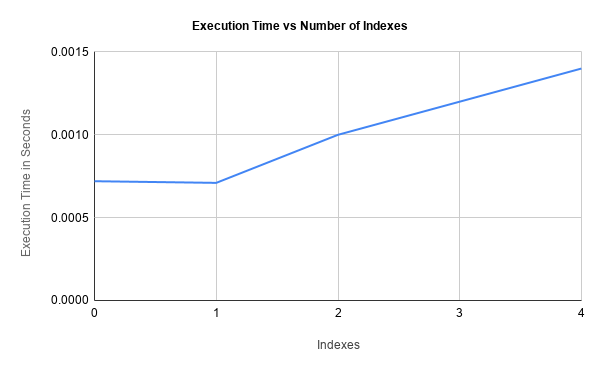

We can observe that as more indexes are added to the table, the execution time of insertion increases, with a small exception for the `idx_nconst` index which is created on the table's primary key, `nconst` .

In [ ]:
query = pd.read_sql("""DROP INDEX idx_primaryname ON namebasics;
INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
VALUES ('nm9999900', 'Emma Stone', '1988-11-06', NULL, NULL, NULL);

CREATE INDEX idx_nconst
ON namebasics (nconst);

-- duration: 0.00061s
INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
VALUES ('nm9999901', 'John Hamm', '1988-03-10', NULL, NULL, NULL);

CREATE INDEX idx_primaryname
ON namebasics (primaryname(288));

-- duration: 0.0041s
INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
VALUES ('nm9999902', 'Heath Ledger', '1988-04-04', '2008-01-22', NULL, NULL);

CREATE INDEX idx_birthyear
ON namebasics (birthyear);

-- duration: 0.0043s
INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
VALUES ('nm9999903', 'Michael Caine', '1933-03-14', NULL, NULL, NULL);

CREATE INDEX idx_age
ON namebasics (age);

-- duration: 0.0043s
INSERT INTO namebasics (nconst, primaryname, birthyear, deathyear, noofmovies, age)
VALUES ('nm9999904', 'Meryl Streep', '1949-06-22', NULL, NULL, NULL);
""", database_connection.connect())